In [2]:
%matplotlib inline
#iDPC-STEM simulation
from abtem import __version__
print('current version:', __version__)
import matplotlib.pyplot as plt
import numpy as np
from abtem import *
from math import pi 
from abtem.transfer import CTF
from abtem.measure import center_of_mass,probe_profile
from abtem import noise

import scipy.optimize as sio
import h5py
import os,sys
from ase.io import read
from ase.build import surface
import math
import json
import sys

import matplotlib as mpl

import matplotlib.offsetbox as mploff
import matplotlib.gridspec as mpgs
from abtem.noise import poisson_noise
from abtem.structures import orthogonalize_cell
from abtem.detect import SegmentedDetector
from abtem.transfer import CTF, scherzer_defocus, point_resolution, energy2wavelength,cartesian2polar
%matplotlib inline

def gauss(kernel_size,sigma):
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size//2
    if sigma<=0:
        sigma = ((kernel_size-1)*0.5-1)*0.3+0.8

    s = sigma**2
    sum_val=0
    for i in range(kernel_size):
        for j in range(kernel_size):
            x,y=i-center,j-center
            kernel[i,j]=np.exp(-(x**2+y**2)/(2*s))
            sum_val += kernel[i,j]

    kernel=kernel/sum_val

    return kernel

def conv_2d(kernel, img, mode='fill'):
    if mode =='fill':
        h = kernel.shape[0]//2
        w = kernel.shape[1]//2
        img = np.pad(img, (h,w), 'reflect')
    
    res_h = img.shape[0]-kernel.shape[0]+1
    res_w = img.shape[1]-kernel.shape[1]+1
    
    res = np.zeros((res_h, res_w))
    
    dh = kernel.shape[0]
    dw = kernel.shape[1]
    for i in range(res_h):
        for j in range(res_w):
            res[i,j] = np.sum(img[i:i+dh, j:j+dw]*kernel)
    return res

def intergrate(dpcx,dpcy,dpc_1):
    (n,m)=dpcx.shape
    fft_x=np.fft.fft2(dpcx)
    fft_y=np.fft.fft2(dpcy)
    fft_x = np.fft.fftshift(fft_x)
    fft_y = np.fft.fftshift(fft_y)
    fft_sum=np.zeros(fft_x.shape,dtype=complex)
    down=complex(0,1)
    for i in range(n):
        for j in range(m):
            fft_sum[i,j]=(i*fft_x[i,j]+j*fft_y[i,j])/(2*pi*down*(i*i+j*j))

    fft_sum[0,0]=1e-12

    iDPC_image=np.fft.ifft2(np.fft.ifftshift(fft_sum))
    iDPC_image=np.real(iDPC_image)
    iDPC_image -= iDPC_image.min()
    iDPC_img=dpc_1.copy()
    iDPC_img.array=iDPC_image
    
    return iDPC_img

def mkdir(path):
    folder=os.path.exists(path)

    if not folder:
        os.makedirs(path)
        print("new folder")

    else:
        print("folder already exists")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


current version: 1.0.0beta32


In [5]:
file_name='ZSM5_modified1_py.cif'
path=file_name[:-4]+'/'
mkdir(path)
thickness=1
dir_out2=path+'ZSM5_modified1_py_z_cell_'+str(thickness)
oritation=(0,1,0)
cell_size=(1,1,thickness)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device='cpu'
FWHM=0.8
print('the current runing cif:', file_name)

defocus=0

new folder
the current runing cif: ZSM5_modified1_py.cif


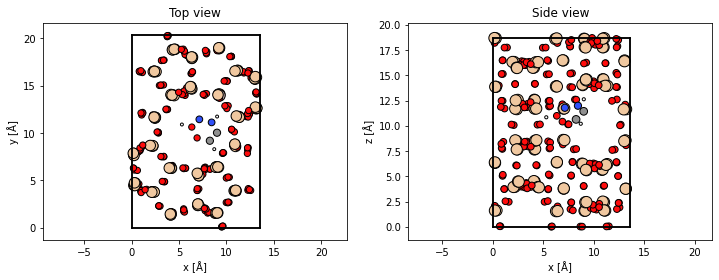

In [6]:
#cif setting
atoms = read(file_name)

atoms = surface(atoms,indices=oritation,layers=1,vacuum=0,periodic=True)
repetitions = cell_size

atoms *= repetitions

#atoms.rotate(0,'y',center='COM')
#atoms.center()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

filename=dir_out2+'_atmos.png'
plt.savefig(filename, bbox_inches='tight', dpi=300)

In [7]:
#To do
#Generating anisotropic Debye-Waller factors for every atom in cif
#atoms.get_positions()[288]

In [8]:
#defining Debye-Waller factor
#To use some real numbers, for example if B = 0.5 Angstroms^2, then u = 0.0796 Angstroms. 
# almost all materials will have about <0.05 < u < 0.12 at 298 K, and you will often find in TEM there is not a large difference in contrast between u=0.08 and u=0.10
# Sometimes you will also find U, the mean-square displacement in papers, which can be used with the expression . 
# B will usually be around 0.5-1.0 Angstrom^2, while U is around 0.01 Angstrom^2, so fairly easy to tell them apart by magnitude alone.

#B1=0.5       #For Si atoms at 298K
#B2=0.5       #For O atoms at 298K
#u1=math.sqrt(B1/8)/pi  # convert DW factor to 
#u2=math.sqrt(B2/8)/pi  # RMS the displacement
#frozen_phonons = FrozenPhonons(atoms, 30,{'Si' : u1, 'O' : u2,'C' :u1,'H':u1,'N' :u1,'Al':u1}, seed=1)
#atoms_configuration= next(iter(frozen_phonons))

#show_atoms(atoms_configuration,title='Top view')

#filename=file_name[:-4]+'_DWF_atmos.png'
#plt.savefig(filename, bbox_inches='tight', dpi=300)

#atoms=frozen_phonons

In [7]:
print(f"Simulation cell: {atoms.cell}")



Simulation cell: Cell([13.5742, 20.382, 18.699249528297])


In [8]:
potential = Potential(atoms, 
                      gpts=2048,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland',
                      device=device)
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.00662802734375, 0.0099521484375)


Text(0.5, 1.0, 'Probe')

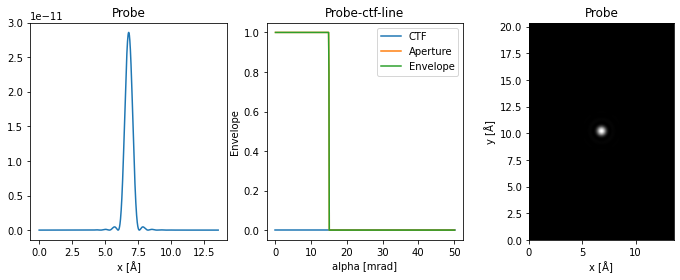

In [9]:
#'C10':25.02, 'C12':56.78, 'phi12':27.1/180pi1000, 'C21':100.5, 'phi21':-148.1/180pi1000, 'C23':1073, 'phi23':-84.9/180pi1000, 'C30':5907, 'C32':3612, 'phi32':32.9/180pi1000, 'C34':3862, 'phi34':170.9/180pi1000, 'C41':19260, 'phi41':95.7/180pi1000, 'C43':32530, 'phi43':96.1/180pi1000, 'C45':39360, 'phi45':-112.6/180pi1000, 'C50':2570000, 'C52':747600, 'phi52':-143.8/180pi1000, 'C54':386300, 'phi54':32.7/180pi1000, 'C56':1646000, 'phi56':82.5/180pi1000

#C10=25.02, C12=56.78, phi12=27.1/180*pi, 
#C21=100.5, phi21=-148.1/180*pi, C23=1073, phi23=-84.9/180*pi, 
#C30=5907, C32=3612, phi32=32.9/180*pi, C34=3862, phi34=170.9/180*pi, 
#C41=19260, phi41=95.7/180*pi, C43=32530, phi43=96.1/180*pi, C45=39360, phi45=-112.6/180*pi, 
#C50=2570000, C52=747600, phi52=-143.8/180*pi, C54=386300, phi54=32.7/180*pi, C56=1646000, phi56=82.5/180*pi

#'defocus': 'C10', 'astigmatism': 'C12', 'astigmatism_angle': 'phi12',
 #                'coma': 'C21', 'coma_angle': 'phi21',
 #                'Cs': 'C30',
 #               'C5': 'C50'

probe = Probe(energy=300e3,semiangle_cutoff=15,rolloff=.1,defocus=defocus,device=device)
#probe = Probe(energy=300e3,semiangle_cutoff=15,focal_spread=30,C10=25.02, C12=56.78, phi12=27.1/180*pi, 
#C21=100.5, phi21=-148.1/180*pi, C23=1073, phi23=84.9/180*pi, 
#C30=5907, C32=-3612, phi32=32.9/180*pi, C34=3862, phi34=170.9/180*pi, 
#C41=19260, phi41=95.7/180*pi, C43=32530, phi43=96.1/180*pi, C45=39360, phi45=-112.6/180*pi, 
#C50=2570000, C52=747600, phi52=-143.8/180*pi, C54=386300, phi54=32.7/180*pi, C56=1646000, phi56=82.5/180*pi)
probe.grid.match(potential)  
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12,4)) 
probe.profile().show(ax=ax1)
ax1.set_title('Probe')
probe.ctf.show(50,ax=ax2) 
ax2.set_title('Probe-ctf-line')
probe.show(ax=ax3) 
ax3.set_title('Probe')

In [10]:
probe.profile().calibrations[0].sampling

0.008287057189568786

(<AxesSubplot: title={'center': 'HAADF'}, xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x182d68370>)

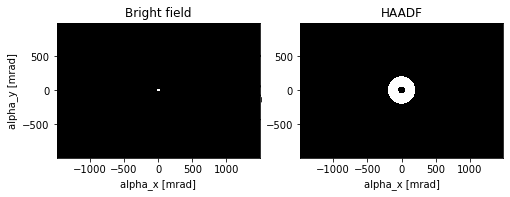

In [11]:
haadf=AnnularDetector(inner=50,outer=200)
bright = AnnularDetector(inner=0, outer=20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

bright.show(probe, ax=ax1, title='Bright field')
haadf.show(probe, ax=ax2, title='HAADF')

(<AxesSubplot: title={'center': 'The 4-quarant Detector'}, xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x186323dc0>)

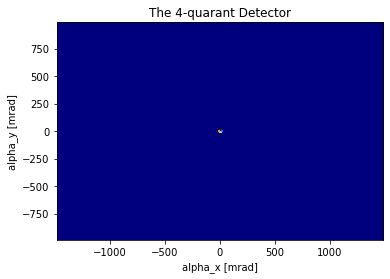

In [12]:
dpc_detector = SegmentedDetector(inner=4,outer=22,nbins_radial=1,nbins_angular=4,rotation=-np.pi/4)
dpc_detector.show(probe,cmap='jet',title='The 4-quarant Detector')

In [13]:
start= (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])
scan_end=(1*potential.extent[0] / repetitions[0], 1*potential.extent[1] / repetitions[1])
#gridscan = GridScan(start=(10,20), end=(30,40),  sampling=probe.ctf.nyquist_sampling * .9)
gridscan = GridScan(start=(0,0), end=scan_end,  sampling=probe.ctf.nyquist_sampling * .9)
#measurement = probe.scan(gridscan,dpc_detector,potential) 
measurement = probe.scan(gridscan,[dpc_detector,haadf, bright],potential)

Potential:   0%|          | 0/19 [00:00<?, ?it/s]

Scan:   0%|          | 0/3174 [00:00<?, ?it/s]

IndexError: index 26616 is out of bounds for axis 1 with size 2048

In [16]:
measurement[0].array.shape


(138, 276, 4)

(<Axes: title={'center': 'DPC_D'}, xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x2b94cc1e5b0>)

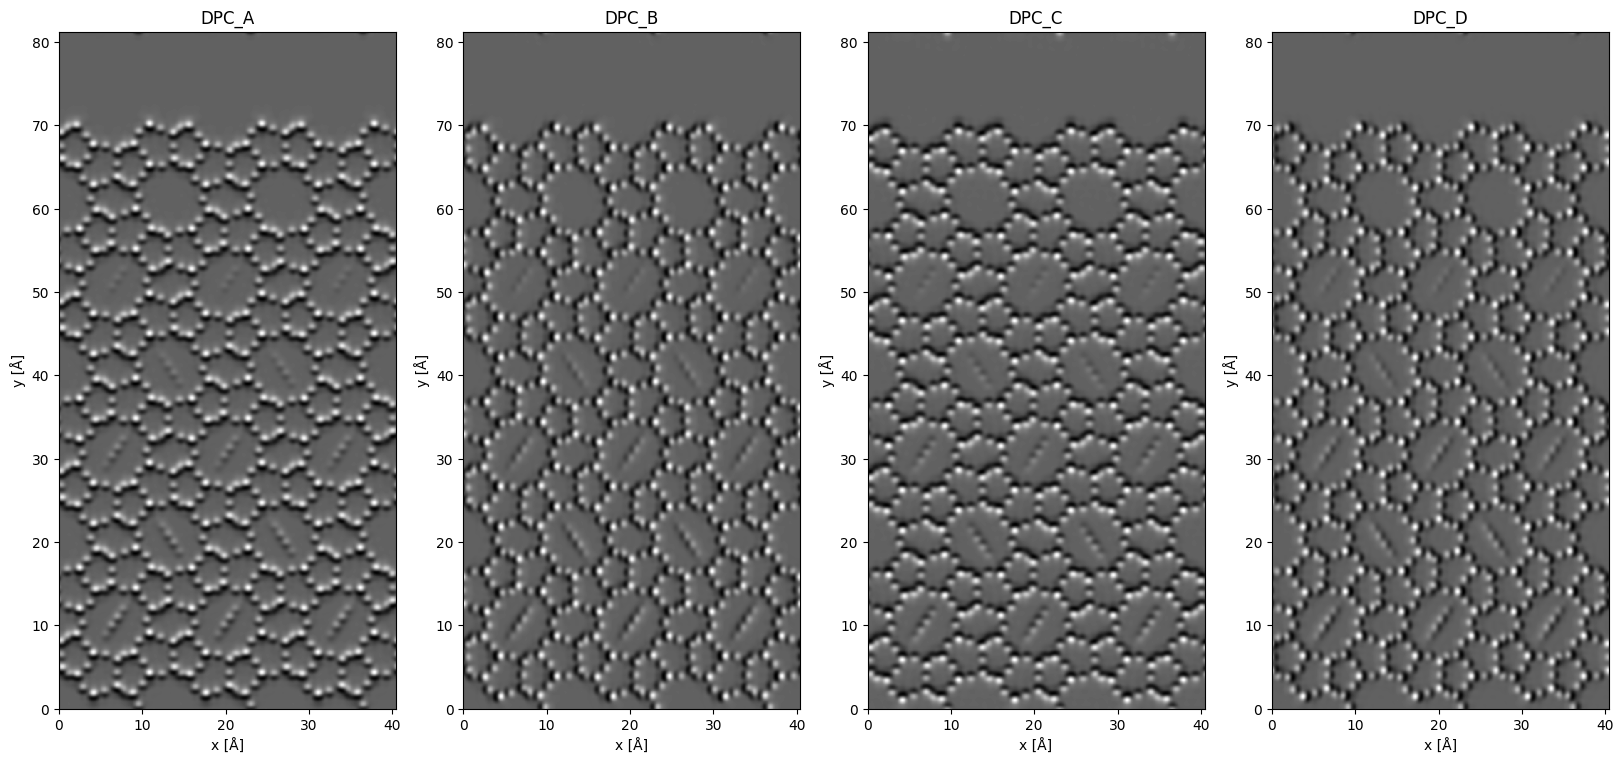

In [17]:
dpc_1=measurement[0][:,:,1].tile((1, 1)).interpolate(0.05)
dpc_2=measurement[0][:,:,2].tile((1, 1)).interpolate(0.05)
dpc_3=measurement[0][:,:,3].tile((1, 1)).interpolate(0.05)
dpc_4=measurement[0][:,:,0].tile((1, 1)).interpolate(0.05)

#dpc_1=noise.poisson_noise(dpc_1,dose)
#dpc_2=noise.poisson_noise(dpc_2,dose)
#dpc_3=noise.poisson_noise(dpc_3,dose)
#dpc_4=noise.poisson_noise(dpc_4,dose)
#negative_values='raise'
dpc_1_array=dpc_1.tile((1, 1)).array
dpc_2_array=dpc_2.tile((1, 1)).array
dpc_3_array=dpc_3.tile((1, 1)).array
dpc_4_array=dpc_4.tile((1, 1)).array


fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,10)) 
dpc_1.tile((1, 1)).show(ax=ax1,title='DPC_A')
dpc_2.tile((1, 1)).show(ax=ax2,title='DPC_B')
dpc_3.tile((1, 1)).show(ax=ax3,title='DPC_C')
dpc_4.tile((1, 1)).show(ax=ax4,title='DPC_D')

#filename=dir_out2+'_DPC.png'
#plt.savefig(filename, bbox_inches='tight', dpi=300)


In [18]:
dpc_1.calibrations[1].sampling


0.04998929765886288

(<Axes: title={'center': 'Ideal_iDPC'}, xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x2b94c5e32e0>)

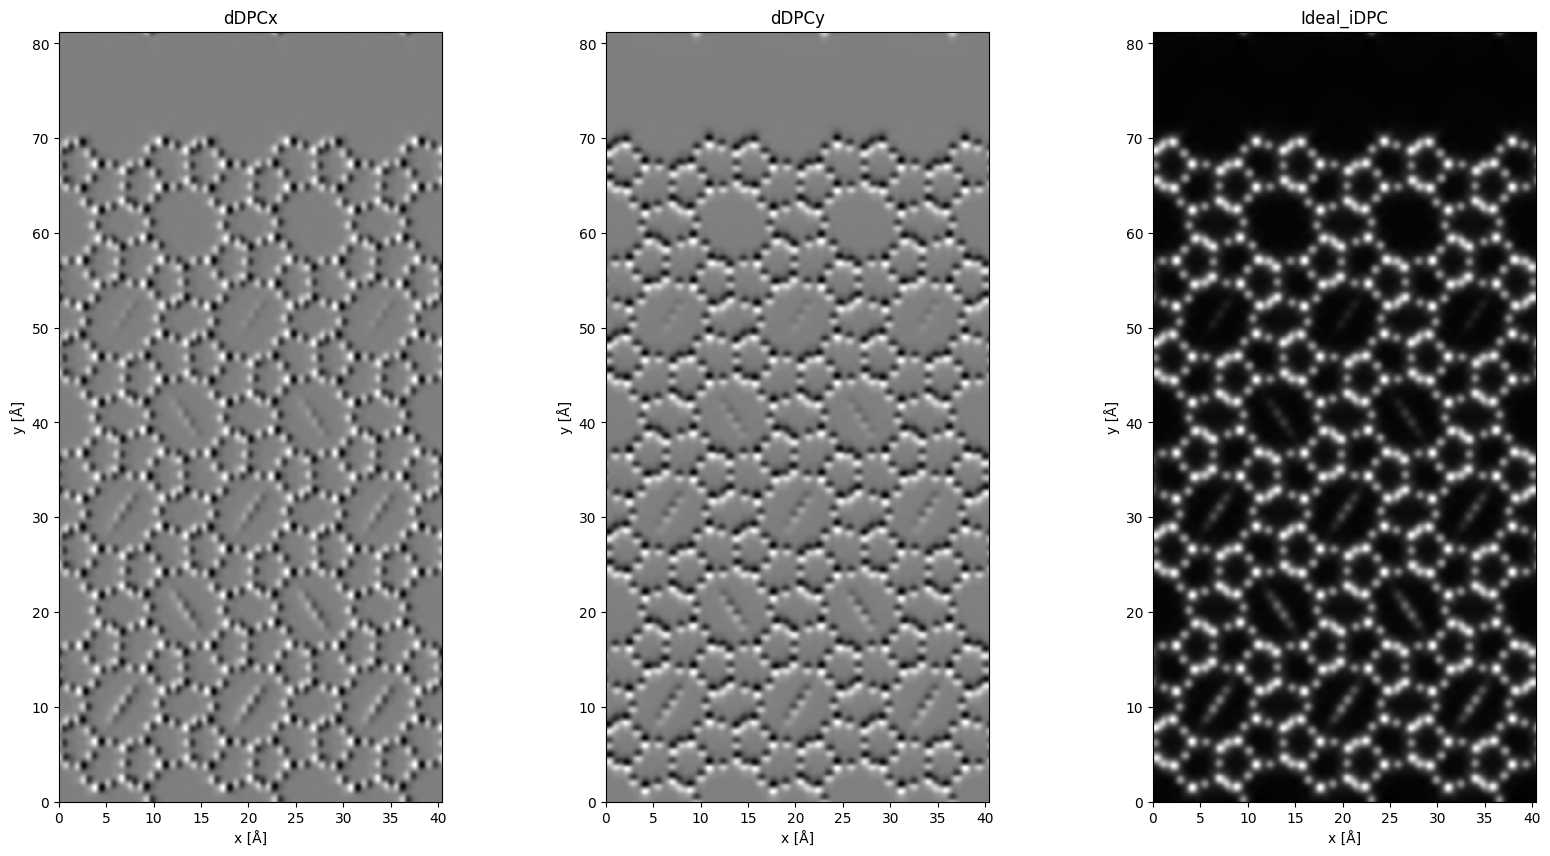

In [19]:
dpc_1.array.shape
dpcy=-(dpc_1_array-dpc_3_array)
dpcx=-(dpc_2_array-dpc_4_array)
ddpc_x=dpc_1.tile((1, 1)).copy()
ddpc_y=dpc_1.tile((1, 1)).copy()
ddpc_x.array=dpcx
ddpc_y.array=dpcy


sampling=(dpc_1.calibrations[0].sampling, dpc_1.calibrations[1].sampling)
ideal_iDPC_array=measure.intgrad2d((dpcx,dpcy),sampling)

ideal_iDPC=ddpc_x.copy()
ideal_iDPC.array=ideal_iDPC_array


fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10)) 
ddpc_x.tile((1, 1)).show(ax=ax1,title='dDPCx')
ddpc_y.tile((1, 1)).show(ax=ax2,title='dDPCy')
ideal_iDPC.tile((1,1)).show(ax=ax3,title='Ideal_iDPC')
#filename=dir_out2+'_dDPC_iDPC.png'
#plt.savefig(filename, bbox_inches='tight', dpi=600)



In [20]:
atoms.cell[0][0]
dpc_1.array.shape[0]

810

gauss fliter FWHM 0.8
The best sigma is  6.756917182812243


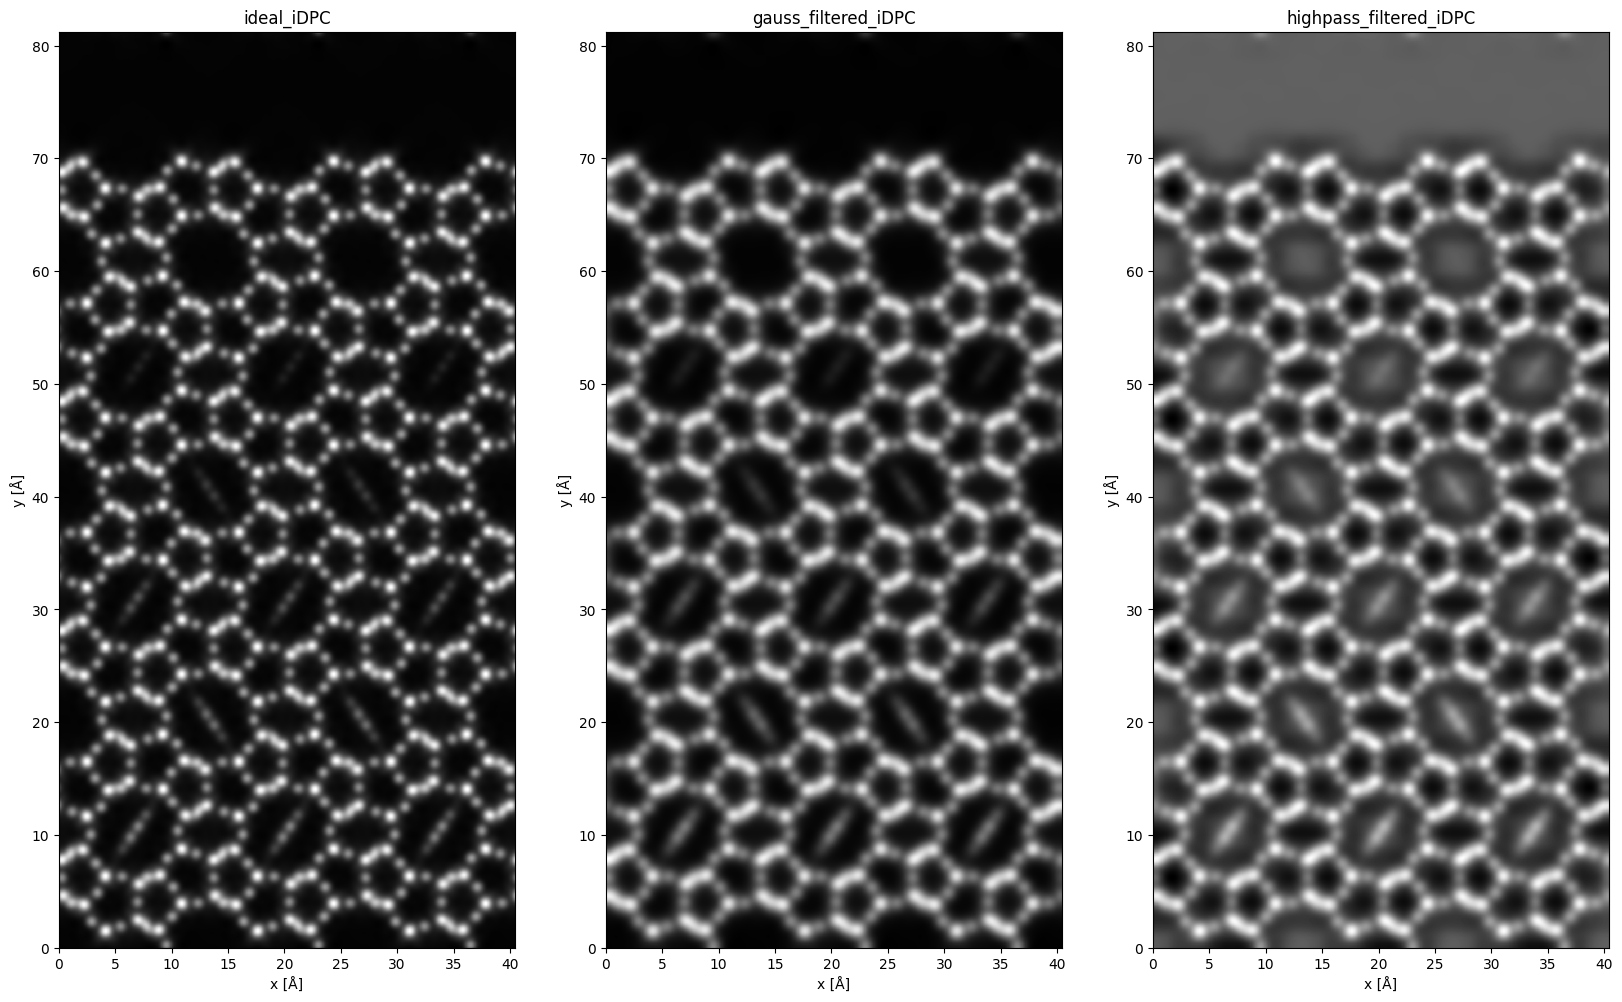

In [24]:
#gauss highpass filter setting
length=atoms.cell[0][0]/(dpc_1.array.shape[0])
kernel_size=101
best_sigma=FWHM/(length*2.355) 
sigma=best_sigma
print("gauss fliter FWHM", FWHM)
print('The best sigma is ', best_sigma)

gauss_kernel=gauss(kernel_size,sigma)
filtered_iDPC=ideal_iDPC.copy()
filtered_iDPC.array=conv_2d(gauss_kernel,ideal_iDPC.array)



kernel_size=101
sigma=300
gauss_kernel=gauss(kernel_size,sigma)

highpass_iDPC=ideal_iDPC.copy()
highpass_iDPC.array=filtered_iDPC.array-conv_2d(gauss_kernel,ideal_iDPC.array)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,15))  
ideal_iDPC.tile((1, 1)).show(ax=ax1,title='ideal_iDPC')
filtered_iDPC.tile((1, 1)).show(ax=ax2,title='gauss_filtered_iDPC')
highpass_iDPC.tile((1, 1)).show(ax=ax3,title='highpass_filtered_iDPC')


ideal_iDPC.interpolate(0.05).tile((1,1)).save_as_image(dir_out2+'_ideal_iDPC'+'_defocus_'+str(defocus)+'_1.tif')
filtered_iDPC.interpolate(0.05).tile((1,1)).save_as_image(dir_out2+'_gauss_iDPC'+'_defocus_'+str(defocus)+'_1.tif')
#highpass_iDPC.interpolate(0.2514).tile((1,1)).save_as_image(dir_out2+'_highpass_iDPC'+'_defocus_'+str(defocus)+'.tif')


In [97]:
#noise
for dose in [10,100,3000]:
    for i in range(1,1001):
        dose_measurement=poisson_noise(measurement, dose=dose)
        dpc_1_noise=dose_measurement[:,:,1].tile((1, 1)).interpolate(0.2514)
        dpc_2_noise=dose_measurement[:,:,2].tile((1, 1)).interpolate(0.2514)
        dpc_3_noise=dose_measurement[:,:,3].tile((1, 1)).interpolate(0.2514)
        dpc_4_noise=dose_measurement[:,:,0].tile((1, 1)).interpolate(0.2514)
        #negative_values='raise'
        dpc_1_array=dpc_1_noise.array
        dpc_2_array=dpc_2_noise.array
        dpc_3_array=dpc_3_noise.array
        dpc_4_array=dpc_4_noise.array

        (m,n)=dpc_1.array.shape
        dpc_1.array.shape
        dpcy=-(dpc_1_array-dpc_3_array)
        dpcx=-(dpc_2_array-dpc_4_array)
        ddpc_x=dpc_1.tile((1, 1)).copy()
        ddpc_y=dpc_1.tile((1, 1)).copy()
        ddpc_x.array=dpcx
        ddpc_y.array=dpcy


        sampling=(dpc_1.calibrations[0].sampling, dpc_1.calibrations[1].sampling)
        ideal_iDPC_array=measure.intgrad2d((dpcx,dpcy),sampling)

        ideal_iDPC=ddpc_x.copy()
        ideal_iDPC.array=ideal_iDPC_array

        length=atoms.cell[0][0]/(dpc_1.array.shape[0])
        kernel_size=101
        best_sigma=FWHM/(length*2.355) 
        sigma=best_sigma

        gauss_kernel=gauss(kernel_size,sigma)
        filtered_iDPC=ideal_iDPC.copy()
        filtered_iDPC.array=conv_2d(gauss_kernel,ideal_iDPC.array)

        kernel_size=101
        sigma=300
        gauss_kernel=gauss(kernel_size,sigma)

        highpass_iDPC=ideal_iDPC.copy()
        highpass_iDPC.array=filtered_iDPC.array-conv_2d(gauss_kernel,ideal_iDPC.array)

        #fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,15))  
        #ideal_iDPC.tile((1, 1)).show(ax=ax1,title='ideal_iDPC')
        #filtered_iDPC.tile((1, 1)).show(ax=ax2,title='gauss_filtered_iDPC')
        #highpass_iDPC.tile((1, 1)).show(ax=ax3,title='highpass_filtered_iDPC')


        ideal_iDPC.interpolate(0.2514).tile((1,1)).save_as_image(dir_out2+'_ideal_iDPC'+'_defocus_'+str(defocus)+'_dose_'+str(dose)+'_'+str(i)+'.tif')
        filtered_iDPC.interpolate(0.2514).tile((1,1)).save_as_image(dir_out2+'_gauss_iDPC'+'_defocus_'+str(defocus)+'_dose_'+str(dose)+'_'+str(i)+'.tif')
   # highpass_iDPC.interpolate(0.2514).tile((1,1)).save_as_image(dir_out2+'_highpass_iDPC'+'_defocus_'+str(defocus)+'_dose_'+str(dose)+'.tif')

Simulation for electron field mapping

gauss fliter FWHM 0.8
The best sigma is  1.3513834365624486


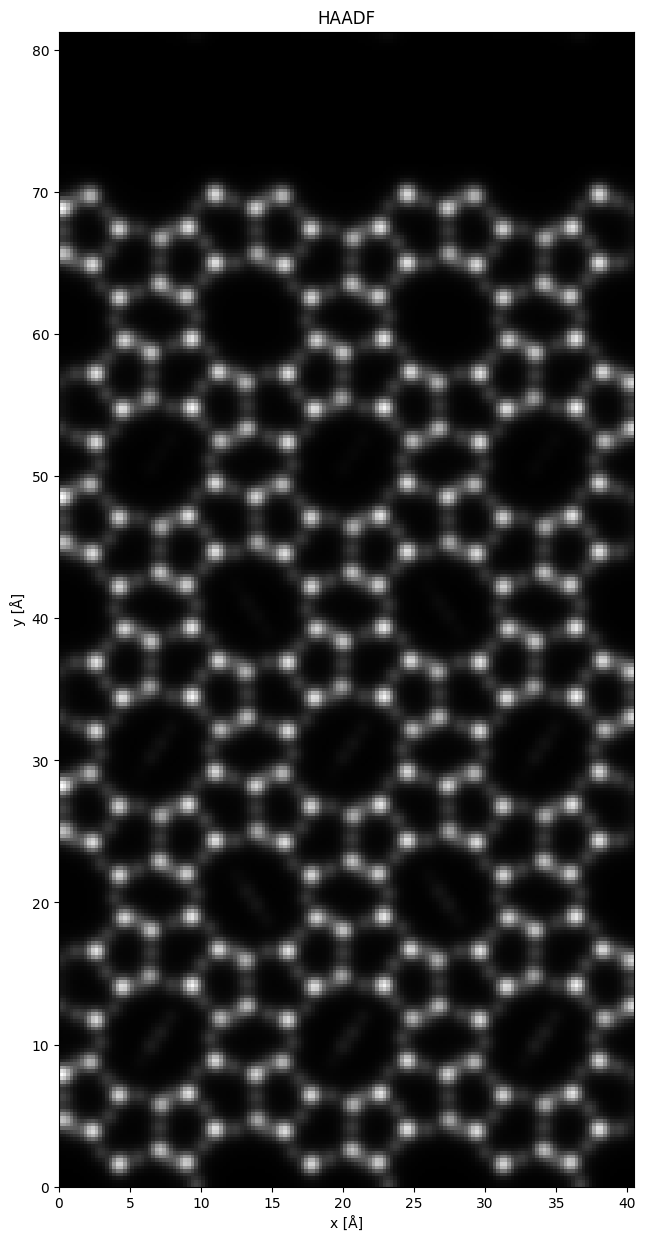

In [25]:
Haadf_measurement=measurement[1].tile((1, 1)).interpolate(0.2514)

#gauss setting
new_measurement=Haadf_measurement
length=atoms.cell[0][0]/Haadf_measurement.array.shape[0]
kernel_size=51
best_sigma=FWHM/(length*2.355)
sigma=best_sigma
print("gauss fliter FWHM", FWHM)
print('The best sigma is ', best_sigma)

gauss_kernel=gauss(kernel_size,sigma)
new_measurement.array=conv_2d(gauss_kernel,new_measurement.array)

fig, (ax1) = plt.subplots(1, 1, figsize=(20,15))  
new_measurement.tile((1, 1)).show(ax=ax1,title='HAADF')

Haadf_measurement.interpolate(0.05).tile((1,1)).save_as_image(dir_out2+'_ideal_Haadf'+'_defocus_'+str(defocus)+'.tif')
new_measurement.interpolate(0.05).tile((1,1)).save_as_image(dir_out2+'_gauss_Haadf'+'_defocus_'+str(defocus)+'.tif')


gauss fliter FWHM 0.8
The best sigma is  1.3513834365624486


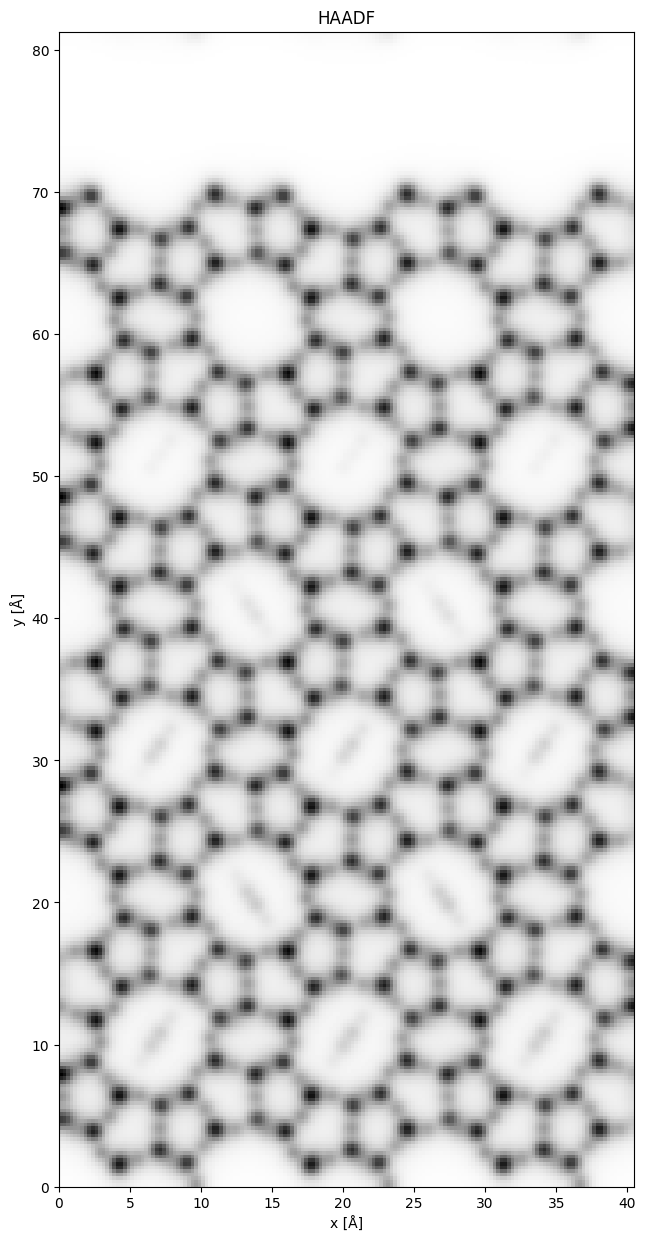

In [26]:
bf_measurement=measurement[2].tile((1, 1)).interpolate(0.2514)

#gauss setting
new_measurement=bf_measurement
length=atoms.cell[0][0]/bf_measurement.array.shape[0]
kernel_size=51
best_sigma=FWHM/(length*2.355)
sigma=best_sigma
print("gauss fliter FWHM", FWHM)
print('The best sigma is ', best_sigma)

gauss_kernel=gauss(kernel_size,sigma)
new_measurement.array=conv_2d(gauss_kernel,new_measurement.array)

fig, (ax1) = plt.subplots(1, 1, figsize=(20,15))  
new_measurement.tile((1, 1)).show(ax=ax1,title='HAADF')

bf_measurement.interpolate(0.05).tile((1,1)).save_as_image(dir_out2+'_ideal_bf'+'_defocus_'+str(defocus)+'.tif')
new_measurement.interpolate(0.05).tile((1,1)).save_as_image(dir_out2+'_gauss_bf'+'_defocus_'+str(defocus)+'.tif')